## TODO

3 - Mutual information / Information value / Information gain
2 - Combination of especific variables [category x cat, float x float, cat x float]  
4 - First algorithms

4 - First eda template


### Import Data


In [10]:
import importlib
import utils
importlib.reload(utils)

import numpy as np
import pandas as pd

from utils import SandEDA

df = pd.read_csv("./database/UCI_Credit_Card.csv")

# Define the specific dates range
start_date = "2023-06-01"
end_date = "2023-09-30"

safra = []
# Generate a random date within the specified range
for i in range(df.shape[0]):
    safra.append(
        pd.to_datetime(
            np.random.choice(pd.date_range(start=start_date, end=end_date))
        ).strftime("%Y%m")
    )

df["safra"] = safra
df.rename(
    columns={
        "default.payment.next.month": "default",
    },
    inplace=True,
)


### Run tests


In [11]:
sandeda = SandEDA(df, "UCI_Credit_Card", "default", "safra")

In [12]:
features_imp = sandeda.promising_features()

In [14]:
features_imp


{'iv': {'Information Value': {'PAY_0': 0.9154404849354484,
   'PAY_5': 0.4780664963105562,
   'PAY_4': 0.4760044819497969,
   'PAY_3': 0.4753375502313929,
   'PAY_6': 0.43484704428825977,
   'SEX': 0.021887679444375738,
   'MARRIAGE': 0.008913611231162374,
   'LIMIT_BAL': 0.008798538003136666,
   'BILL_AMT1': 0.0026887843257444727,
   'ID': 0.0022229746377720435,
   'BILL_AMT6': 0.0021850120688350003,
   'BILL_AMT2': 0.0020474821698487737,
   'BILL_AMT4': 0.0019324479766264502,
   'BILL_AMT3': 0.0012416010957331872,
   'safra': 0.00026211297743918786,
   'EDUCATION': 0.0,
   'PAY_2': 0.0,
   'BILL_AMT5': -0.0011709607348114222,
   'AGE': -0.002528214011136787,
   'PAY_AMT2': -0.05396399221074663,
   'PAY_AMT3': -0.056100208259427076,
   'PAY_AMT1': -0.060440890708068004,
   'PAY_AMT6': -0.09288783632697756,
   'PAY_AMT5': -0.09308813079671893,
   'PAY_AMT4': -0.10102398559129239}},
 'mi': {'PAY_0': 0.07613288672742802,
  'PAY_2': 0.051805873747876374,
  'PAY_3': 0.04166071427891249,
  

In [9]:
res_dict = sandeda.calc_general()

In [10]:
vars_time_dict = sandeda.variables_espec_time()

In [11]:
vars_dict = sandeda.variables_espec()

##### Visualization prototypes of the important features

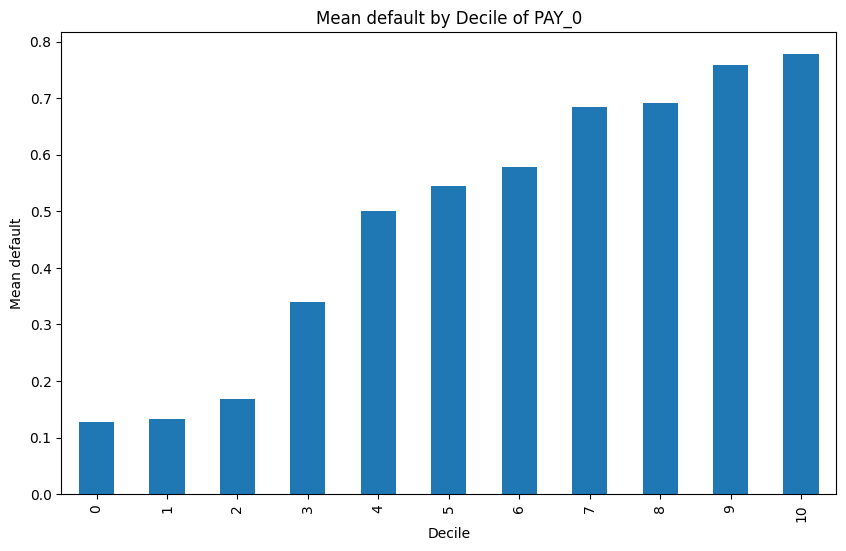

In [25]:
import matplotlib.pyplot as plt

def plot_decile_target_mean(df, variable, target):
    # Create deciles
    if df[variable].dtype == 'object' or df[variable].nunique() < 20:
        df[variable] = df[variable].astype('category').cat.codes
        cat_codes = df.groupby(variable)[target].mean().sort_values().index
        cat_mapping = {cat: idx for idx, cat in enumerate(cat_codes)}
        df[variable] = df[variable].map(cat_mapping)
        df['decile'] = df[variable]def plot_decile_target_mean(df, variable, target):
    # Create deciles
    if df[variable].dtype == 'object' or df[variable].nunique() < 20:
        df[variable] = df[variable].astype('category').cat.codes
        cat_codes = df.groupby(variable)[target].mean().sort_values().index
        cat_mapping = {cat: idx for idx, cat in enumerate(cat_codes)}
        df[variable] = df[variable].map(cat_mapping)
        df['decile'] = df[variable]
    else:
        df['decile'] = pd.qcut(df[variable], 10, labels=False)
    
    # Calculate the mean of the target variable for each decile
    decile_means = df.groupby('decile')[target].mean()
    
    # Plot the decile means
    plt.figure(figsize=(10, 6))
    decile_means.plot(kind='bar')
    plt.xlabel('Decile')
    plt.ylabel(f'Mean {target}')
    plt.title(f'Mean {target} by Decile of {variable}')
    plt.show()

# Example usage
plot_decile_target_mean(df, 'PAY_0', 'default')
    # Calculate the mean of the target variable for each decile
    decile_means = df.groupby('decile')[target].mean()
    
    # Plot the decile means
    plt.figure(figsize=(10, 6))
    decile_means.plot(kind='bar')
    plt.xlabel('Decile')
    plt.ylabel(f'Mean {target}')
    plt.title(f'Mean {target} by Decile of {variable}')
    plt.show()

# Example usage
plot_decile_target_mean(df, 'PAY_0', 'default')

In [ ]:
from scipy.stats import entropy

# Calculate the entropy for each group
grouped = (
    df.groupby("safra")["MARRIAGE"].value_counts(normalize=True).unstack(fill_value=0)
)
entropy_values = grouped.apply(entropy, axis=1)

print(entropy_values)

safra
202306    0.754469
202307    0.750202
202308    0.764251
202309    0.746327
dtype: float64
